In [4]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/3d/73/fe30c2daaaa0713420d0382b16fbb761409f532c56bdcc514bf7b6262bb6/pytz-2019.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6d/1b/6b7c1c95c1455ea746af0c47a8cb956894d368b77f4b79a691ffb196bfdb/scikit_learn-0.20.3-cp37-cp37m-win32.whl
  Using cached https://files.pythonhosted.org/packages/a7/cd/6b8df093ca7e7f12a66004f9edc2e2628dd4692f34cc284c874814a40e6a/scipy-1.2.1-cp37-cp37m-win32.whl


You are using pip version 18.1, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, \
    GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
import sklearn.metrics as metrics
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.tree import export_graphviz
from graphviz import Source
from random import randint


### Used Functions

In [6]:
def string_to_timestamp(date_string):  
    '''
    Function coverting a time string to a float timestamp
    '''
    time_stamp = time.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return time.mktime(time_stamp)


def create_initial_dataset():
    '''
    Function constructing the dataset from the initial csv file, keeping the categorical data
    '''
    src = 'data_for_student_case.csv'
    ah = open(src, 'r')
    x_labeled = []
    data = []
    conversion_dict = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP': 1.13355} 
    ah.readline()  # skip first line
    for line_ah in ah:
        if line_ah.strip().split(',')[9] == 'Refused':  # skip Refused transactions
            continue
        if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
            continue
        issuercountry = line_ah.strip().split(',')[2]  # country code
        txvariantcode = line_ah.strip().split(',')[3]  # type of card: visa/master
        issuer_id = float(line_ah.strip().split(',')[4])  # bin card issuer identifier
        amount = float(line_ah.strip().split(',')[5])  # transaction amount in minor units
        currencycode = line_ah.strip().split(',')[6]
        amount = conversion_dict[currencycode] * amount  # currency conversion
        shoppercountry = line_ah.strip().split(',')[7]  # country code
        interaction = line_ah.strip().split(',')[8]  # online transaction or subscription
        label  = 1 if line_ah.strip().split(',')[9] == 'Chargeback' else 0
        verification = line_ah.strip().split(',')[10]  # shopper provide CVC code or not
        cvcresponse = int(line_ah.strip().split(',')[11])  # 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
        if cvcresponse > 2:
            cvcresponse = 3
        year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').year
        month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').month
        day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').day
        creationdate = str(year_info) + '-' + str(month_info) + '-' + str(day_info)  # Date of transaction
        creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])  # Date of transaction-time stamp
        accountcode = line_ah.strip().split(',')[13]  # merchant’s webshop
        mail_id = int(float(line_ah.strip().split(',')[14].replace('email', '')))  # mail
        ip_id = int(float(line_ah.strip().split(',')[15].replace('ip', '')))  # ip
        card_id = int(float(line_ah.strip().split(',')[16].replace('card', '')))  # card
        data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                     shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                     accountcode, mail_id, ip_id, card_id, label, creationdate])  # add the interested features here
    data = sorted(data, key=lambda k: k[-1])
    for item in data:  # split data into x,y
        x_labeled.append(item[0:-1])
    df = pd.DataFrame(x_labeled)
    df.columns = ['issuercountry', 'txvariantcode', 'issuer_id', 'amount', 'currencycode',
                  'shoppercountry', 'interaction', 'verification', 'cvcresponse', 'creationdate_stamp',
                  'accountcode', 'mail_id', 'ip_id', 'card_id', 'labels']  # column names of the dataset
    df.to_csv('data_for_plots.csv')
    
    
def make_boxplot(data):
    '''
    Function for the visualization task - Boxplot about the accountcode-to-amount feature relationship
    '''
    ax = sns.boxplot(x="accountcode", y="amount", hue="labels", data=data,
                palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["benign", "fraudulent"])
    plt.xlabel("Merchant's webshop")
    plt.ylabel("Amount in euros")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_accountcode_amount.png')
    print('boxplot created')

    
def make_boxplot_money(data):
    '''
    Function for the visualization task - Boxplot about the labels-to-amount relationship
    '''
    ax = sns.boxplot(x="labels", y="amount", data=data,
                palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    ax.set_xticklabels(['benign', 'fraudulent'])
    plt.ylabel("Amount in euros")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_labels_amount.png')
    print('boxplot created')

    
def make_barplot(data):
    '''
    Function for the visualization task - Barplot about the percentage of cvcresponce code per class 
    '''
    cvc_counts = (data.groupby(['labels'])['cvcresponse'].value_counts(normalize=True).rename('percentage').mul(100)
                         .reset_index().sort_values('cvcresponse'))
    ax = sns.barplot(x='cvcresponse', y='percentage', data=cvc_counts, hue='labels',
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']})
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["benign", "fraudulent"], loc='upper right')
    plt.xlabel("CVC code")
    plt.ylabel("Percentage of occurrences")
    plt.grid()
    plt.show()
#     plt.savefig('plots/barplot_cvc.png')
    print('barplot created')


def make_barplot_issued(data):
    '''
    Function for the visualization task - Barplot about the percentage of issuercountry code per class 
    '''
    cvc_counts = (data.groupby(['labels'])['issuercountry'].value_counts(normalize=True).rename('percentage').mul(100)
                         .reset_index())
    ax = sns.barplot(x='issuercountry', y='percentage', data=cvc_counts, hue='labels',
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']})
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["benign", "fraudulent"], loc='upper right')
    ax.set(xlim=(-0.5, 15.5))
    plt.xlabel("Issuer Country")
    plt.ylabel("Percentage of occurrences")
    plt.grid()
    plt.show()
#     plt.savefig('plots/barplot_issuer.png')
    print('barplot created')


def make_boxplot_card_type(data):
    '''
    Function for the visualization task - Boxplot about the amount-to-card type feature relationship
    '''
    ax = sns.boxplot(x="amount", y="txvariantcode", hue="labels", data=data,
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["benign", "fraudulent"])
    plt.xlabel("Amount in euros")
    plt.ylabel("Type of card")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_card_type.png')
    print('boxplot created')


def make_boxplot_issuer_id(data):
    '''
    Function for the visualization task - Boxplot about the labels-to-issuer id relationship
    '''
    ax = sns.boxplot(x="labels", y="issuer_id", data=data,
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    ax.set_xticklabels(['benign', 'fraudulent'])
    plt.ylabel("Card issuer identifier")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_labels_issuer_id.png')
    print('boxplot created')


def make_boxplot_ip(data):
    '''
    Function for the visualization task - Boxplot about the labels-to-ip id relationship
    '''
    ax = sns.boxplot(x="labels", y="ip_id", data=data,
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    ax.set_xticklabels(['benign', 'fraudulent'])
    plt.ylabel("IP address")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_labels_ip.png')
    print('boxplot created')

    
def plot_roc(fpr, tpr, roc_auc, fpr_smote, tpr_smote, roc_auc_smote, clf_name):
    '''
    Function for the imbalance task - Plots the ROC curve for both the SMOTEd and unSMOTEd classifier
    '''
    plt.figure()
    plt.title('{} - Receiver Operating Characteristic'.format(clf_name))
    plt.plot(fpr, tpr, 'r', label='AUC unSMOTEd = %0.2f' % roc_auc)
    plt.plot(fpr_smote, tpr_smote, 'g', label='AUC SMOTEd = %0.2f' % roc_auc_smote)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
#     plt.savefig('imbalance_plots/{}_ROC.png'.format(clf_name), bbox_inches='tight')
    

def plot_confusion_matrix(y_true, y_pred, clf_name, classes, smote, normalize=False, title=None, cmap=plt.cm.Blues):
    '''
    Function for the imbalance task - Plots the confusion matrix of a classifier 
    '''
    if not title:
        if normalize:  # check if the normalized confusion matrix is to be plotted
            title = '{} - Normalized confusion matrix'.format(clf_name+smote)
        else:
            title = '{} - Confusion matrix, without normalization'.format(clf_name+smote)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
#     fig.savefig('imbalance_plots/{}_confusion.png'.format(clf_name+smote))
    return ax


def plot_prec_rec(precision, recall, precision_smote, recall_smote):
    '''
    Function for the imbalance task - Plots the Precision-Recall curve for both the SMOTEd and unSMOTEd classifier
    '''
    plt.figure()
    plt.title('{} - Precision-recall curve'.format(clf_name))
    plt.plot(recall, precision, 'r', label='Precision-recall UnSMOTEd')
    plt.plot(recall_smote, precision_smote, 'g', label='Precision-recall SMOTEd')
    plt.legend(loc='upper right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
#     plt.savefig('imbalance_plots/{}_Prec_Rec.png'.format(clf_name), bbox_inches='tight')
    
    
def plot_decision_tree(clf):
    '''
    Function for the classification task - Plots the structure of the trained decision tree
    '''
    features = np.array(['issuercountry', 'txvariantcode', 'issuer_id', 'amount', 'currencycode',
                         'shoppercountry', 'interaction', 'verification', 'cvcresponse', 'creationdate_stamp',
                         'accountcode', 'mail_id', 'ip_id', 'card_id'])
    fearure_nums = [0, 4, 5, 8, 10, 12]  # features to be used
    graph = Source(export_graphviz(clf, out_file=None, max_depth=3, feature_names=features[fearure_nums],
                    class_names=['benign', 'fraudulent'], filled=True, rounded=True, special_characters=True,
                    proportion=False, precision=2))
    png_bytes = graph.pipe(format='png')
    with open('dtree.png', 'wb') as f:
        f.write(png_bytes)
    

def make_clf_SMOTE(usx, usy, clf, clf_name, normalize=False, smoted=False):
    '''
    Function for the imbalance task - Trains and tests the classifier clf using 10-fold cross-validation
    If normalize flag is True then the data are being normalised
    If smoted flag is True then SMOTE is used to oversample the minority class 
    '''
    print('----------{}----------'.format(clf_name))
    totalTP, totalFP, totalFN, totalTN = 0, 0, 0, 0
    total_y_test = []
    total_y_prob = []
    total_y_pred = []
    skf = StratifiedKFold(n_splits=10)  # 10-fold stratified cross validation
    for train_index, test_index in skf.split(usx, usy):
        x_train, x_test = usx[train_index], usx[test_index]
        y_train, y_test = usy[train_index], usy[test_index]

        if smoted:  # SMOTE applied
            sm = SMOTE(sampling_strategy=0.5)
            x_train, y_train = sm.fit_resample(x_train, y_train)

        if normalize: # normalization applied
            scaler = RobustScaler().fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

        clf.fit(x_train, y_train)  # training of the classifier
        y_predict = clf.predict(x_test)  # testing the classifier
        y_proba = clf.predict_proba(x_test)  # class-wise probabilities of each test sample
        # needed for roc curve
        total_y_test += list(y_test)
        total_y_prob += list(y_proba[:, 1])
        total_y_pred += list(y_predict)

        for i in range(len(y_predict)):
            if y_predict[i] and y_proba[i, 1] <= 0.65:   # adding more "cost" to the misclassification in the fraudulent class
                y_predict[i] = 0
        for i in range(len(y_predict)):
            if y_test[i] and y_predict[i]:
                totalTP += 1
            if not y_test[i] and y_predict[i]:
                totalFP += 1
            if y_test[i] and not y_predict[i]:
                totalFN += 1
            if not y_test[i] and not y_predict[i]:
                totalTN += 1

    print('TOTAL TP: ' + str(totalTP))
    print('TOTAL FP: ' + str(totalFP))
    print('TOTAL FN: ' + str(totalFN))
    print('TOTAL TN: ' + str(totalTN))

    total_y_test = np.array(total_y_test)
    total_y_prob = np.array(total_y_prob)
    total_y_pred = np.array(total_y_pred)
    fpr, tpr, _ = metrics.roc_curve(total_y_test, total_y_prob)  # create FPR ans TPR values for the ROC curve plotting
    precision, recall, _ = precision_recall_curve(total_y_test, total_y_prob)
    roc_auc = metrics.auc(fpr, tpr)  # Area under curve calculation
    if smoted:
        plot_confusion_matrix(total_y_test, total_y_pred, clf_name, ['benign', 'fraudulent'], ' SMOTEd',
                            normalize=True, title=None, cmap=plt.cm.Blues)
    else:
        plot_confusion_matrix(total_y_test, total_y_pred, clf_name, ['benign', 'fraudulent'], '',
                              normalize=True, title=None, cmap=plt.cm.Blues)
    return fpr, tpr, roc_auc, precision, recall


def make_clf(usx, usy, clf, clf_name, sampling, normalize=False):
    '''
    Function for the classification task - Trains and tests the classifier clf using 10-fold cross-validation
    If normalize flag is True then the data are being normalised
    The sampling parameter sets the type of sampling to be used
    '''
    print('----------{} with {}----------'.format(clf_name, sampling))
    totalTP, totalFP, totalFN, totalTN = 0, 0, 0, 0
    plot_ind = randint(0, 9)
    j = 0
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(usx, usy):
        x_train, x_test = usx[train_index], usx[test_index]
        y_train, y_test = usy[train_index], usy[test_index]
        
        # sampling applied
        if sampling == 'SMOTE':
            x_train, y_train = SMOTE(sampling_strategy=0.3).fit_resample(x_train, y_train)
        elif sampling == 'ADASYN':
            x_train, y_train = ADASYN(sampling_strategy=0.3).fit_resample(x_train, y_train)
        elif sampling == 'ENN':
            x_train, y_train = EditedNearestNeighbours().fit_resample(x_train, y_train)
        elif sampling == 'Tomek':
            x_train, y_train = TomekLinks().fit_resample(x_train, y_train)
        elif sampling == 'SMOTETomek':
            x_train, y_train = SMOTETomek(sampling_strategy=0.3).fit_resample(x_train, y_train)
        elif sampling == 'SMOTEENN':
            x_train, y_train = SMOTEENN(sampling_strategy=0.3).fit_resample(x_train, y_train)
        elif sampling == 'NCR':
            x_train, y_train = NeighbourhoodCleaningRule().fit_resample(x_train, y_train)
        elif sampling == 'OSS':
            x_train, y_train = OneSidedSelection().fit_resample(x_train, y_train)

        if normalize:
            scaler = StandardScaler().fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

        clf.fit(x_train, y_train)
        
        # Decision tree plot for the white-box algorithm needs
        # if plot_ind == j and clf_name == 'DecisionTreeClassifier':
        #     plot_decision_tree(clf)

        y_predict = clf.predict(x_test)

        for i in range(len(y_predict)):
            if y_test[i] and y_predict[i]:
                totalTP += 1
            if not y_test[i] and y_predict[i]:
                totalFP += 1
            if y_test[i] and not y_predict[i]:
                totalFN += 1
            if not y_test[i] and not y_predict[i]:
                totalTN += 1
        j += 1

    print('TOTAL TP: ' + str(totalTP))
    print('TOTAL FP: ' + str(totalFP))
    print('TOTAL FN: ' + str(totalFN))
    print('TOTAL TN: ' + str(totalTN))

### Visualization Task

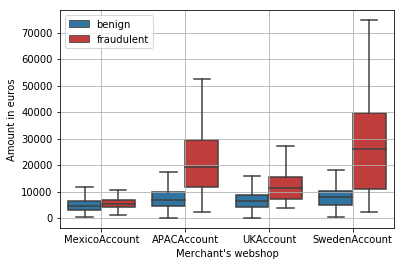

boxplot created


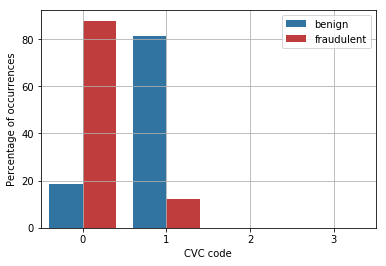

barplot created


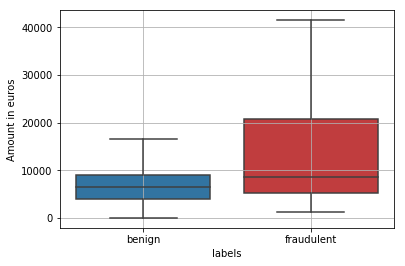

boxplot created


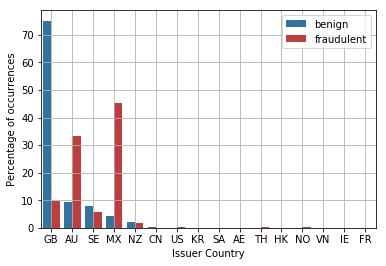

barplot created


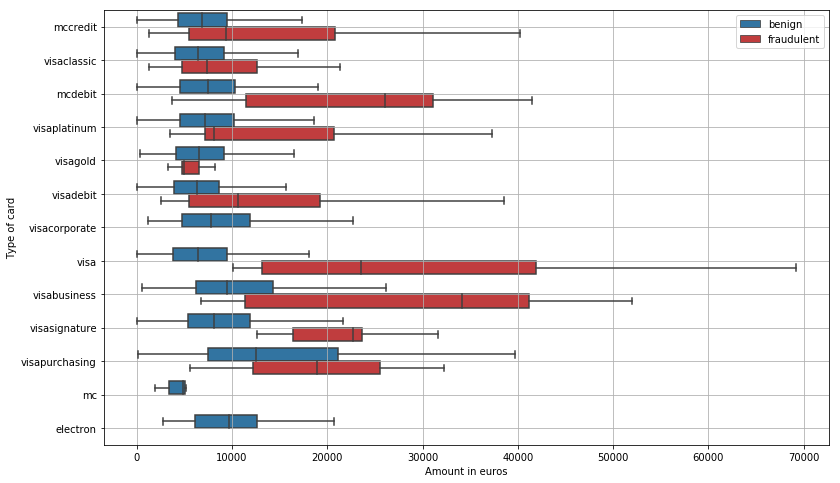

boxplot created


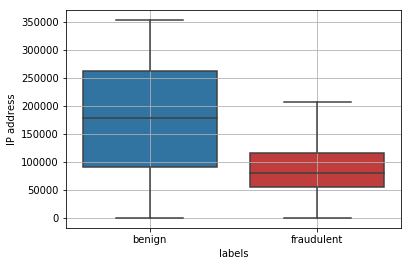

boxplot created


In [7]:
# create_initial_dataset()  # to be used if the "data_for_plots.csv" is not already created
data = pd.read_csv('data_for_plots.csv')
plt.figure()
make_boxplot(data)
plt.figure()
make_barplot(data)
plt.figure()
make_boxplot_money(data)
plt.figure()
make_barplot_issued(data)
plt.figure(figsize=(13, 8))
make_boxplot_card_type(data)
# plt.figure()
# make_boxplot_issuer_id(data)
plt.figure()
make_boxplot_ip(data)

### Numeric dataset creation

In [ ]:
src = 'data_for_student_case.csv'
ah = open(src, 'r')
x = []  # contains features
y = []  # contains labels
data = []
color = []
conversion_dict = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP': 1.13355}
(issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
 verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in range(10)]
(issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
 verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in range(10)]
ah.readline()  # skip first line
for line_ah in ah:
    if line_ah.strip().split(',')[9] == 'Refused':  # remove the row with 'refused' label, since it's uncertain about fraud
        continue
    if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
        continue
    bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])  # date reported flaud
    issuercountry = line_ah.strip().split(',')[2]  # country code
    issuercountry_set.add(issuercountry)
    txvariantcode = line_ah.strip().split(',')[3]  # type of card: visa/master
    txvariantcode_set.add(txvariantcode)
    issuer_id = float(line_ah.strip().split(',')[4])  # bin card issuer identifier
    amount = float(line_ah.strip().split(',')[5])  # transaction amount in minor units
    currencycode = line_ah.strip().split(',')[6]
    currencycode_set.add(currencycode)
    amount = conversion_dict[currencycode] * amount  # currency conversion
    shoppercountry = line_ah.strip().split(',')[7]  # country code
    shoppercountry_set.add(shoppercountry)
    interaction = line_ah.strip().split(',')[8]  # online transaction or subscription
    interaction_set.add(interaction)
    if line_ah.strip().split(',')[9] == 'Chargeback':
        label = 1  # label fraud
    else:
        label = 0  # label save
    verification = line_ah.strip().split(',')[10]  # shopper provide CVC code or not
    verification_set.add(verification)
    cvcresponse = int(line_ah.strip().split(',')[11])  # 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
    if cvcresponse > 2:
        cvcresponse = 3
    year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').year
    month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').month
    day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').day
    creationdate = str(year_info) + '-' + str(month_info) + '-' + str(day_info)  # Date of transaction
    creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])  # Date of transaction-time stamp
    accountcode = line_ah.strip().split(',')[13]  # merchant’s webshop
    accountcode_set.add(accountcode)
    mail_id = int(float(line_ah.strip().split(',')[14].replace('email', '')))  # mail
    mail_id_set.add(mail_id)
    ip_id = int(float(line_ah.strip().split(',')[15].replace('ip', '')))  # ip
    ip_id_set.add(ip_id)
    card_id = int(float(line_ah.strip().split(',')[16].replace('card', '')))  # card
    card_id_set.add(card_id)
    data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                 shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                 accountcode, mail_id, ip_id, card_id, label, creationdate])  # add the interested features here

data = sorted(data, key=lambda k: k[9])  # data sorted according to transaction-time stamp

for item in data:  # split data into x,y
    x.append(item[0:-2])
    y.append(item[-2])
    
# map number to each categorial feature
for item in list(issuercountry_set):
    issuercountry_dict[item] = list(issuercountry_set).index(item)
for item in list(txvariantcode_set):
    txvariantcode_dict[item] = list(txvariantcode_set).index(item)
for item in list(currencycode_set):
    currencycode_dict[item] = list(currencycode_set).index(item)
for item in list(shoppercountry_set):
    shoppercountry_dict[item] = list(shoppercountry_set).index(item)
for item in list(interaction_set):
    interaction_dict[item] = list(interaction_set).index(item)
for item in list(verification_set):
    verification_dict[item] = list(verification_set).index(item)
for item in list(accountcode_set):
    accountcode_dict[item] = list(accountcode_set).index(item)
print(len(list(card_id_set)))

# modify categorial feature to number in data set
for item in x:
    item[0] = issuercountry_dict[item[0]]
    item[1] = txvariantcode_dict[item[1]]
    item[4] = currencycode_dict[item[4]]
    item[5] = shoppercountry_dict[item[5]]
    item[6] = interaction_dict[item[6]]
    item[7] = verification_dict[item[7]]
    item[10] = accountcode_dict[item[10]]

# The "original_data.csv" numeric dataset is created
des = 'original_data.csv'
ch_dfa = open(des, 'w')

ch_dfa.write(
    'issuercountry, txvariantcode, issuer_id, amount, currencycode, shoppercountry, interaction, '
    'verification, cvcresponse, creationdate_stamp, accountcode, mail_id, ip_id, card_id, label')
ch_dfa.write('\n')

sentence = []
for i in range(len(x)):
    for j in range(len(x[i])):
        sentence.append(str(x[i][j]))
    sentence.append(str(y[i]))
    ch_dfa.write(','.join(sentence))
    ch_dfa.write('\n')
    sentence = []
    ch_dfa.flush()

### Imbalance Task

----------KNeighborsClassifier----------
TOTAL TP: 10
TOTAL FP: 71
TOTAL FN: 335
TOTAL TN: 236282


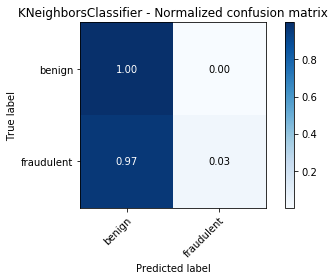

----------KNeighborsClassifier----------
TOTAL TP: 100
TOTAL FP: 7691
TOTAL FN: 245
TOTAL TN: 228662


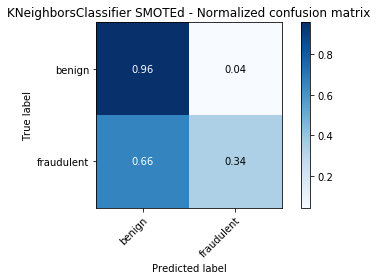

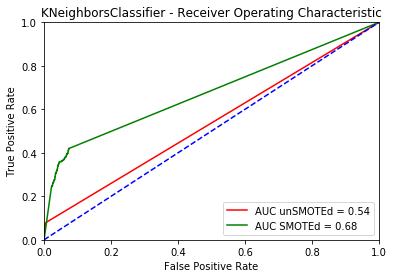

----------LogisticRegression----------


KeyboardInterrupt: 

In [9]:
filename = 'original_data.csv'
data = pd.read_csv(filename)
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

x = np.delete(x, [2, 4, 5, 6, 7, 9, 11, 13], 1)  # specific features are kept - selection done mainly according to the 
                                                 #  relationships identified in the visualization part
# dictionary with the tested classifiers
clfs = {'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=3, algorithm='auto', weights='distance')
        , 'LogisticRegression': LogisticRegression(solver='newton-cg')
        , 'NaiveBayes': GaussianNB()
        , 'AdaBoostClassifier': AdaBoostClassifier(n_estimators=50)
        , 'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
        , 'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=100)
        , 'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100)
        , 'VotingClassifier': VotingClassifier(estimators=[
                ('knn', neighbors.KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', weights='distance')),
                ('lr', LogisticRegression(solver='newton-cg')),
                ('gnb', GaussianNB())
                ], voting='soft')
        }
for clf_name, clf in clfs.items():  # check all the classifiers both with and without SMOTE 
    usx = np.copy(x)
    usy = np.copy(y)
    if clf_name == 'LogisticRegression':
        fpr, tpr, roc_auc, precision, recall = make_clf_SMOTE(usx, usy, clf, clf_name, normalize=True)
        fpr_smote, tpr_smote, roc_auc_smote, precision_smote, recall_smote = \
            make_clf_SMOTE(usx, usy, clf, clf_name, normalize=True, smoted=True)
    else:
        fpr, tpr, roc_auc, precision, recall = make_clf_SMOTE(usx, usy, clf, clf_name)
        fpr_smote, tpr_smote, roc_auc_smote, precision_smote, recall_smote = \
            make_clf_SMOTE(usx, usy, clf, clf_name, smoted=True)
    plot_roc(fpr, tpr, roc_auc, fpr_smote, tpr_smote, roc_auc_smote, clf_name)
    # plot_prec_rec(precision, recall, precision_smote, recall_smote)

### Classification Task

In [10]:
filename = 'original_data.csv'
data = pd.read_csv(filename)
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

x = np.delete(x, [1, 2, 3, 6, 7, 9, 11, 13], 1)  # specific features are kept 

# dicctionaries with the two classifiers to be tested
clfs = {'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', class_weight='balanced')  # white-box 
        , 'RandomForestClassifier': RandomForestClassifier(n_estimators=50, criterion='entropy',
                                                           class_weight='balanced')  # black-box
        }
for smlp in ['SMOTE', 'ADASYN', 'Tomek', 'OSS', 'ENN', 'SMOTETomek', 'SMOTEENN']:  # check different types of sampling
    for clf_name, clf in clfs.items():
        usx = np.copy(x)
        usy = np.copy(y)
        make_clf(usx, usy, clf, clf_name, smlp)

----------DecisionTreeClassifier with SMOTE----------
TOTAL TP: 215
TOTAL FP: 13334
TOTAL FN: 130
TOTAL TN: 223019
----------RandomForestClassifier with SMOTE----------


KeyboardInterrupt: 

### Bonus Task